In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#For converting between geolocal and numerical ages
from pyrolite.util.time import Timescale

import scipy

import sys
sys.path.insert(1, '../pygplates_rev28_python37_win64')
import pygplates

import ptt

import glob
import os

import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [7]:
df=pd.read_csv("petlab_withgrids.csv")
#print(df.columns.values)
df

,Sample_ID,Collection,Coll_No,Plot_unit,Feature_Type,Feature_Name,Top_Depth,Bottom_Depth,Field_Number,Collection_Date,...,ReconPlateID,gridage,gridcrust,gridsubcrust,gridlith,gridsublith,gridsed,gridsubsed,gridserp,gridsubserp
0,32257,GNS P (P),40894,Whakaari,Surface,NaN,NaN,NaN,NaN,1981-01-01 00:00:00,...,839.0,27.324570,0.000006,0.000000,0.000004,0.000004,0.000046,0.000000,0.0,0.000000
1,125909,GNS P (P),79818,Arc,Surface,NaN,NaN,NaN,LS1,40220,...,81315.0,105.385642,0.000009,0.000067,0.000004,0.000004,0.000006,0.000038,0.0,0.000593
2,169088,other,RVAN-17-13.1,Arc,Dredge,Nesmeyanov-N17-13,NaN,NaN,NaN,NaN,...,839.0,27.209710,0.000006,0.000020,0.000004,0.000004,0.000045,0.000006,0.0,0.000004
3,106981,other,BFH-MP112,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,8065.0,93.313096,0.000008,0.000019,0.000004,0.000004,0.000121,0.000050,0.0,0.000002
4,107013,other,BFH-MP279,Horomaka,Surface,NaN,NaN,NaN,NaN,33604,...,8065.0,93.313096,0.000008,0.000019,0.000004,0.000004,0.000121,0.000050,0.0,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,109562,other,87-144A,Continent basement,Dredge,Sonne 36-57,2400,2700,unknown,1994-01-01 00:00:00,...,885.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
968,64286,GNS P (P),73035,Continent basement,Drillcore,ODP-824C,411.92,NaN,"133-824C-18R-1,42-45",32973,...,801.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969,44824,GNS P (P),57235,Austral,Drillcore,Pakaha-1,3360,3363,Pakaha,28126,...,813.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
970,44823,GNS P (P),57234,Austral,Drillcore,Parara-1,3799,3802,Parara,27760,...,81315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(df.columns.tolist())

['Sample_ID', 'Collection', 'Coll_No', 'Plot_unit', 'Feature_Type', 'Feature_Name', 'Top_Depth', 'Bottom_Depth', 'Field_Number', 'Collection_Date', 'Date_Rounding', 'Collectors', 'Country_Name', 'NZMG_Sheet', 'NZMG_East', 'NZMG_North', 'Latitude', 'Longitude', 'Method', 'Accuracy', 'Site_Description', 'In_Situ', 'Rock_Description', 'Colour', 'Litho2014_strat_name', 'Informal_strat_unit', 'Rock_Types', 'Age_Min', 'Age_Max', 'Sample_Types', 'Lab_Sample_ID(s)', 'Material(s)', 'Part_Analysed', 'Analysis_ID(s)', 'Investigator(s)', 'Analysis_Method(s)', 'Geochron_Method(s)', 'Laboratory(s)', 'Lab_Number(s)', 'Analysis_Date(s)', 'Analysis_Date_Rounding(s)', 'Analysis_Publication(s)', 'Analysis_Bib_Ref(s)', 'Analysis_Comment(s)', 'age_sample_result_Ma', 'age_sample_2sig_err_abs', 'SiO2', 'TiO2', 'Al2O3', 'FeOT', 'Fe2O3T', 'Fe2O3', 'FeO', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'Cr2O3', 'H2O_plus', 'H2O_minus', 'CO2', 'LOl', 'Majors_total', 'As', 'Ba', 'Ce', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'E

In [21]:
print(df.dtypes.tolist())

[dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('float64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype

In [25]:
sigvars=['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'Fe2O3T', 'Fe2O3', 'FeO', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'Cr2O3', 'H2O_plus', 'H2O_minus', 'CO2', 'LOl', 'Majors_total', 'As', 'Ba', 'Ce', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'Ga', 'Gd', 'Hf', 'Ho', 'La', 'Lu', 'Nb', 'Nd', 'Ni', 'Pb', 'Pr', 'Rb', 'Sc', 'Sm', 'Sr', 'Ta', 'Tb', 'Th', 'Tm', 'U', 'V', 'Y', 'Yb', 'Zn', 'Zr', 'He4_raw_nnc', 'He4_corr_nnc', 'He_R_Ra_raw', 'He_R_Ra_corr', 'He_R_Ra_cor_err', 'dO18', 'Rb87_Sr86', 'Sr87_Sr86', 'Sr87_Sr86_err_abs', 'Sm147_Nd144', 'Nd143_Nd144', 'Nd143_Nd144_err_abs', 'Lu176_Hf177', 'Hf176_Hf177', 'Hf176_Hf177_err_abs', 'Pb206_Pb204', 'Pb206_Pb204_err_abs', 'Pb207_Pb204', 'Pb207_Pb204_err_abs', 'Pb208_Pb204', 'Pb208_Pb204_err_abs', 'Sr87_86i_calc', 'Nd143_144i_calc', 'eNdi_calc', 'Hf176_177i_calc', 'eHfi_calc', 'Pb206_204i_calc', 'Pb207_204i_calc', 'Pb208_204i_calc', 'Age_Num', 'Age', 'ReconLon', 'ReconLat', 'ReconAge', 'ReconPlateID', 'gridage', 'gridcrust', 'gridsubcrust', 'gridlith', 'gridsublith', 'gridsed', 'gridsubsed', 'gridserp', 'gridsubserp']

<AxesSubplot:>

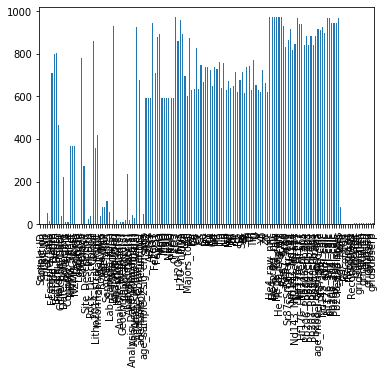

In [23]:
#How many NaNs per feature?

vc_nulls = df.apply(lambda x: x.isnull().value_counts()).T[True]
#vc_nulls.hist() # if you want a histogram of these counts
## or if you wanted to plot the null count of each column as a bar
vc_nulls.plot(kind = 'bar')

In [27]:
#limitPer = len(df1) * .05
#df2 = df1[sigvars].dropna(thresh=limitPer,axis=1)

In [28]:
#Just keep the rows that have CO2
df2=df1[df1['CO2'].notna()]
df2.dropna(axis=1,inplace=True)

#Replace text with values
df2[sigvars].replace(["<0.01","<0.05","<0.3","<0.4","<0.5","<0.6","<0.7","<1","<1.0","<10.0","<2.0","<3.0","<5.0","<50.0"],[0.01,0.05,0.3,0.4,0.5,0.6,0.7,1,1.0,10.0,2.0,3.0,5.0,50.0],inplace=True)
df2[sigvars].replace(["bd"],[0.0],inplace=True)

In [29]:
df2.columns

Index(['Sample_ID', 'Collection', 'Coll_No', 'Feature_Type', 'Collection_Date',
       'Collectors', 'Country_Name', 'Latitude', 'Longitude', 'In_Situ',
       'Rock_Description', 'Rock_Types', 'Age_Min', 'Age_Max', 'Sample_Types',
       'Lab_Sample_ID(s)', 'Material(s)', 'Analysis_ID(s)', 'Investigator(s)',
       'Analysis_Method(s)', 'Laboratory(s)', 'Analysis_Date(s)',
       'Analysis_Date_Rounding(s)', 'Analysis_Publication(s)',
       'age_sample_result_Ma', 'age_sample_2sig_err_abs', 'SiO2', 'TiO2',
       'Al2O3', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'H2O_plus', 'CO2',
       'Majors_total', 'Age_Num', 'Age', 'ReconLon', 'ReconLat', 'ReconAge',
       'ReconPlateID', 'gridage', 'gridcrust', 'gridsubcrust', 'gridlith',
       'gridsublith', 'gridsed', 'gridsubsed', 'gridserp', 'gridsubserp'],
      dtype='object')

In [27]:
df['Rock_Types']

0                          basaltic
1             andesitic & lava flow
2                               NaN
3                       peralkaline
4                       peralkaline
                   ...             
967                        gabbroic
968    greyschist & lutaceous (mst)
969                        granitic
970                        granitic
971                             NaN
Name: Rock_Types, Length: 972, dtype: object

In [28]:
sigvars=['SiO2', 'TiO2',
       'Al2O3', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'H2O_plus', 'CO2',
       'Majors_total', 'Age_Num', 'Age', 'ReconLon', 'ReconLat', 'ReconAge',
       'ReconPlateID', 'gridage', 'gridcrust', 'gridsubcrust', 'gridlith',
       'gridsublith', 'gridsed', 'gridsubsed', 'gridserp', 'gridsubserp']

catvars=['Plot_Unit','Rock_Types','Age_Min','Age_Max']

In [29]:
dfsub=df[sigvars]

In [30]:
np.shape(dfsub)

(972, 27)

<Figure size 432x288 with 0 Axes>

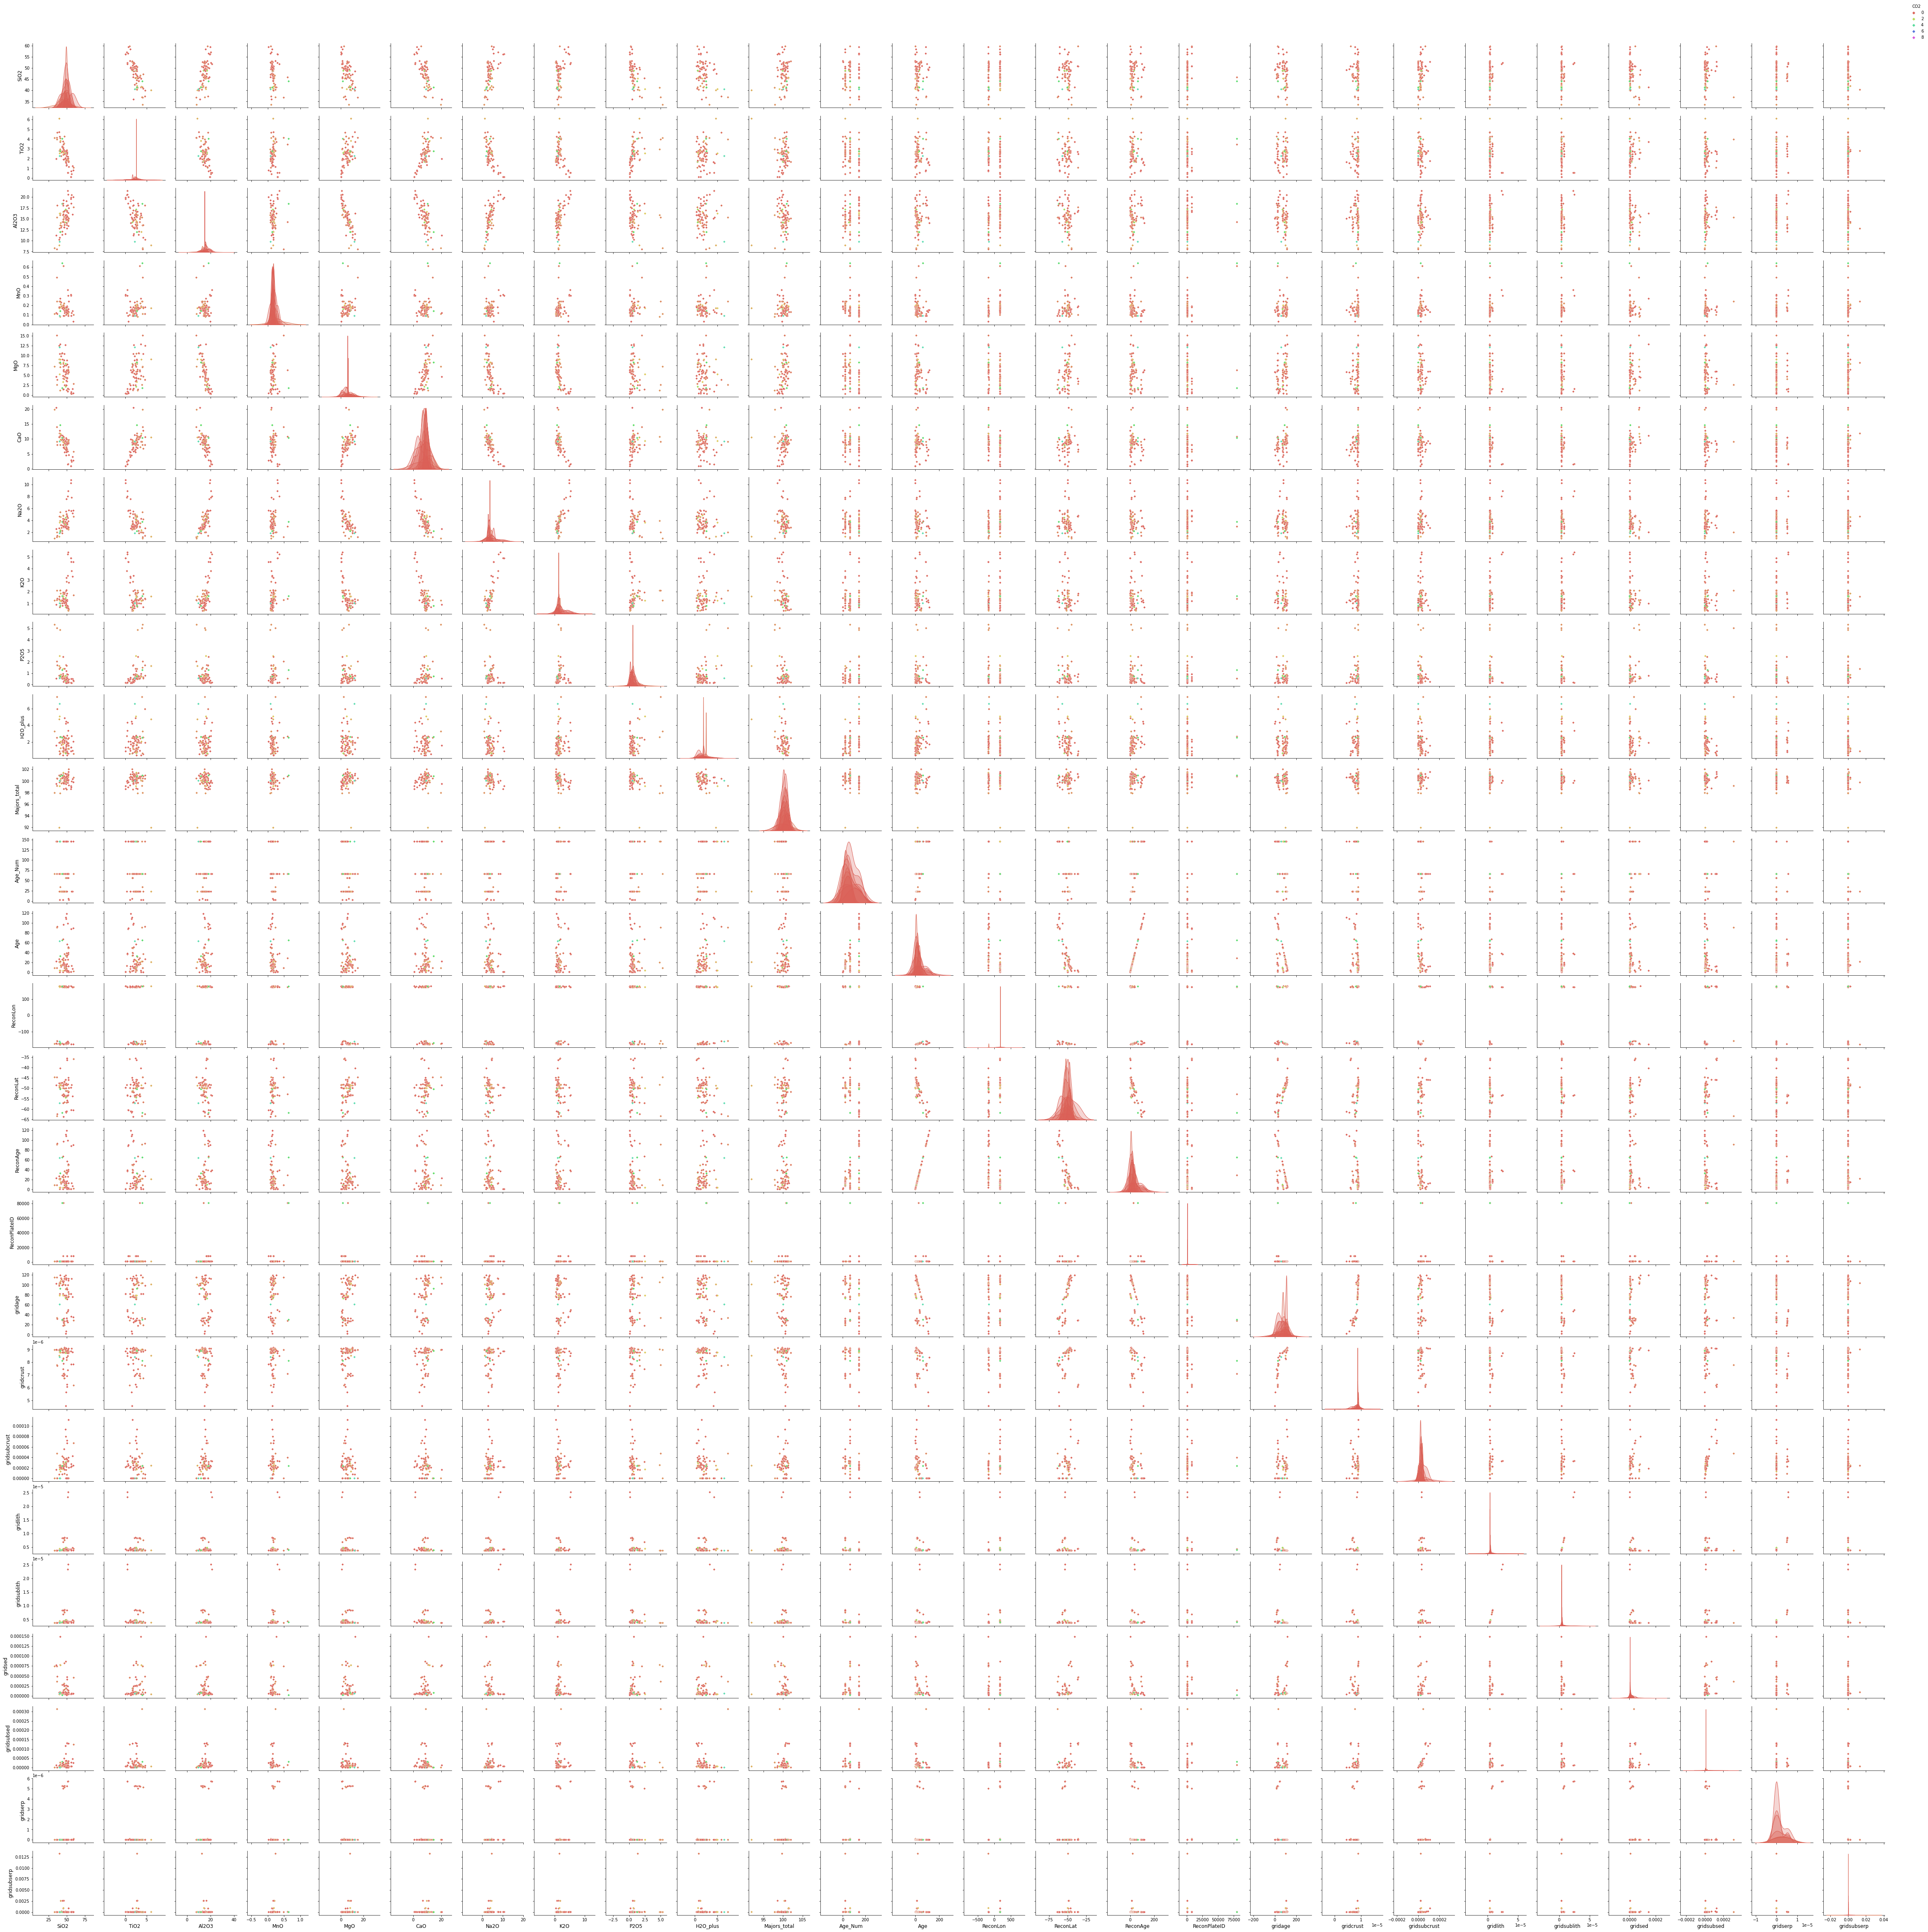

In [35]:
#sns.pairplot(dfsub,hue="ReconAge")
#dfsub.columns[91:100].tolist()+ ['ReconAge'] + ['CO2'] 

# Plot all the columns, break it up because there are too many
# plt.figure()
# cols_to_plot = dfsub.columns[0:10].tolist() + ['ReconAge'] 
# sns.pairplot(dfsub[cols_to_plot], hue ="ReconAge",palette="hls")
# plt.show()

# plt.figure()
# cols_to_plot = dfsub.columns[10:20].tolist() + ['ReconAge'] 
# sns.pairplot(dfsub[cols_to_plot], hue ="ReconAge",palette="hls")
# plt.show()

# plt.figure()
# cols_to_plot = dfsub.columns[20:30].tolist() + ['ReconAge'] 
# sns.pairplot(dfsub[cols_to_plot], hue ="ReconAge",palette="hls")
# plt.show()

# plt.figure()
# cols_to_plot = dfsub.columns.tolist() 
# sns.pairplot(dfsub[cols_to_plot], hue ="ReconAge",palette="Spectral")
# plt.show()

plt.figure()
cols_to_plot = dfsub.columns.tolist() 
sns.pairplot(dfsub[cols_to_plot], hue ="CO2",palette="hls")
plt.show()


In [140]:
g.axes[0,1].set_xlim((0,2))

(0.0, 2.0)

In [38]:
#CO2, ReconAge

#sns.pairplot(df, y_vars="ReconAge", x_vars=sigvars9,hue ="CO2",palette="Spectral")
#sns.pairplot(df1, y_vars="CO2", x_vars=sigvars9,hue ="ReconAge",palette="hls")


In [49]:
#Create the 'feature vector' and a 'target classification vector'
features=df[sigvars+catvars].values
targets=df.CO2.values

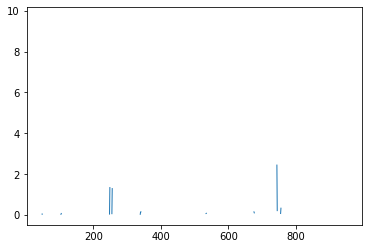

In [47]:
plt.plot(df.CO2.values)

In [48]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(targets.reshape(1, -1))

IterativeImputer(random_state=0)

In [289]:
targets=pd.qcut(df2.CO2,5,labels=False)
targets

48     0
49     0
70     0
104    0
105    1
      ..
912    0
924    1
940    0
945    0
955    0
Name: CO2, Length: 81, dtype: int64

In [290]:
#Create the ML classifier with numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
   ('imputer', SimpleImputer(strategy='constant')),
   ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, sigvars),
        ('cat', categorical_transformer, catvars)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])


Random Forest...
Done RF
RF 10-fold cross validation Scores: [0.444 0.625 0.5   0.75  0.5   0.625 0.25  0.375 0.625 0.375]
SCORE Mean: 0.51 STD: 0.14 



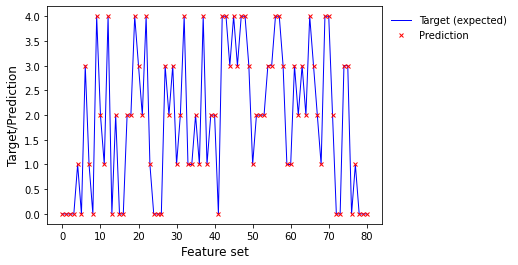

In [291]:
#Train the random forest
print('Random Forest...')

rf.fit(features,targets)
print("Done RF")

scores = cross_val_score(rf, features,targets, cv=10)
print("RF 10-fold cross validation Scores:", scores)
print("SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores), "\n")

plt.plot(targets.values,'b-',label='Target (expected)')
plt.plot(rf.predict(features),'rx',label='Prediction')
plt.xlabel("Feature set")
plt.ylabel("Target/Prediction")
plt.legend()

In [292]:
ft_imp=[]
ft_lab=[]
np.set_printoptions(precision=3,suppress=True)
for i,lab in enumerate(np.append(sigvars,rf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(catvars))):
    #if rf.steps[1][1].feature_importances_[i] > 1*np.mean(rf.steps[1][1].feature_importances_): 
    #print(i, rf.steps[1][1].feature_importances_[i],lab )
    print("%1.3f \t %s" % (rf.steps[1][1].feature_importances_[i],lab))
    ft_imp.append(rf.steps[1][1].feature_importances_[i])
    ft_lab.append(lab)

0.041 	 SiO2
0.029 	 TiO2
0.038 	 Al2O3
0.028 	 MnO
0.030 	 MgO
0.039 	 CaO
0.037 	 Na2O
0.026 	 K2O
0.032 	 P2O5
0.039 	 H2O_plus
0.216 	 CO2
0.034 	 Majors_total
0.009 	 Age_Num
0.040 	 Age
0.024 	 ReconLon
0.025 	 ReconLat
0.029 	 ReconAge
0.011 	 ReconPlateID
0.024 	 gridage
0.025 	 gridcrust
0.027 	 gridsubcrust
0.023 	 gridlith
0.025 	 gridsublith
0.037 	 gridsed
0.032 	 gridsubsed
0.007 	 gridserp
0.030 	 gridsubserp
0.004 	 Rock_Types_basaltic
0.001 	 Rock_Types_basaltic & arenaceous (sst) & rudaceous (cgl, br)
0.001 	 Rock_Types_basaltic & basanitic
0.002 	 Rock_Types_basaltic & hypabyssal: basic
0.000 	 Rock_Types_basaltic & pyroclastic rock
0.001 	 Rock_Types_basaltic & rudaceous (cgl, br)
0.001 	 Rock_Types_basanitic
0.001 	 Rock_Types_basanitic & hypabyssal: basic
0.002 	 Rock_Types_basanitic & lava flow
0.000 	 Rock_Types_gabbroic
0.000 	 Rock_Types_hypabyssal: acid & syenitic
0.001 	 Rock_Types_hypabyssal: basic & gabbroic
0.000 	 Rock_Types_peralkaline & trachytic
0.001

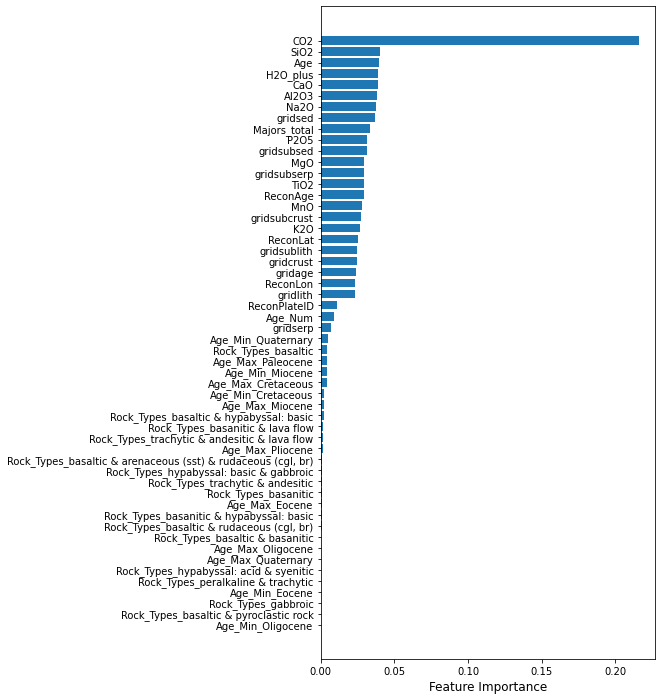

In [293]:
ft_imps, ft_labs = (list(t) for t in zip(*sorted(zip(ft_imp,ft_lab))))

datalength=len(ft_imp)

#Create a new figur
#fig = plt.figure(figsize=(10,10),dpi=150)
fig,ax = plt.subplots(figsize=(6,12))

#Plot the bar graph
rects=ax.barh(np.arange(0, datalength, step=1),ft_imps)

#Label the axes
ax.set_yticks(np.arange(0, datalength, step=1))
ax.set_yticklabels(ft_labs)

ax.set_xlabel('Feature Importance')

#Print the feature importance to compare with plot
np.set_printoptions(precision=3,suppress=True)
# print("Importance \t Feature")
# for i,label in enumerate(ft_lab):
#     print("%1.3f \t\t %s" % (ft_imp[i],ft_lab[i]))

plt.show()